In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.io import *
from fastai.conv_learner import *
from fastai.column_data import *

In [2]:
PATH='data/comics/'

In [3]:
# get_data("https://s3.amazonaws.com/text-datasets/nietzsche.txt", f'{PATH}nietzsche.txt')
text = open(f'{PATH}characters.txt').read()
print('corpus length:', len(text))

corpus length: 20955


In [4]:
text[:600]

'A-Bomb (HAS)\nA.I.M.\nAaron Stack\nAbomination (Emil Blonsky)\nAbomination (Ultimate)\nAbsorbing Man\nAbyss\nAbyss (Age of Apocalypse)\nAdam Destine\nAdam Warlock\nAegis (Trey Rollins)\nAgent Brand\nAgent X (Nijo)\nAgent Zero\nAgents of Atlas\nAginar\nAir-Walker (Gabriel Lan)\nAjak\nAjaxis\nAkemi\nAlain\nAlbert Cleary\nAlbion\nAlex Power\nAlex Wilder\nAlexa Mendez\nAlexander Pierce\nAlice\nAlicia Masters\nAlpha Flight\nAlpha Flight (Ultimate)\nAlvin Maker\nAmadeus Cho\nAmanda Sefton\nAmazoness\nAmerican Eagle (Jason Strongbow)\nAmiko\nAmora\nAmphibian (Earth-712)\nAmun\nAncient One\nAncient One (Ultimate)\nAngel (Thomas Halloway)\nAnge'

In [5]:
chars = sorted(list(set(text)))
vocab_size = len(chars)+1
print('total chars:', vocab_size)

total chars: 75


In [6]:
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

In [7]:
idx = [char_indices[c] for c in text]
idx[:20]

[21, 8, 22, 61, 59, 48, 1, 5, 28, 21, 39, 6, 0, 21, 9, 29, 9, 33, 9, 0]

In [8]:
''.join(indices_char[i] for i in idx[:70])

'A-Bomb (HAS)\nA.I.M.\nAaron Stack\nAbomination (Emil Blonsky)\nAbomination'

In [9]:
cs = 3
c1_dat = [idx[i] for i in range(0, len(idx) - cs, cs)]
c2_dat = [idx[i+1] for i in range(0, len(idx) - cs, cs)]
c3_dat = [idx[i+2] for i in range(0, len(idx) - cs, cs)]
c4_dat = [idx[i+3] for i in range(0, len(idx) - cs, cs)]

In [10]:
x1 = np.stack(c1_dat)
x2 = np.stack(c2_dat)
x3 = np.stack(c3_dat)

In [11]:
y = np.stack(c4_dat)

In [12]:
x1.shape, y.shape

((6984,), (6984,))

In [13]:
n_hidden = 256
n_fac = 42

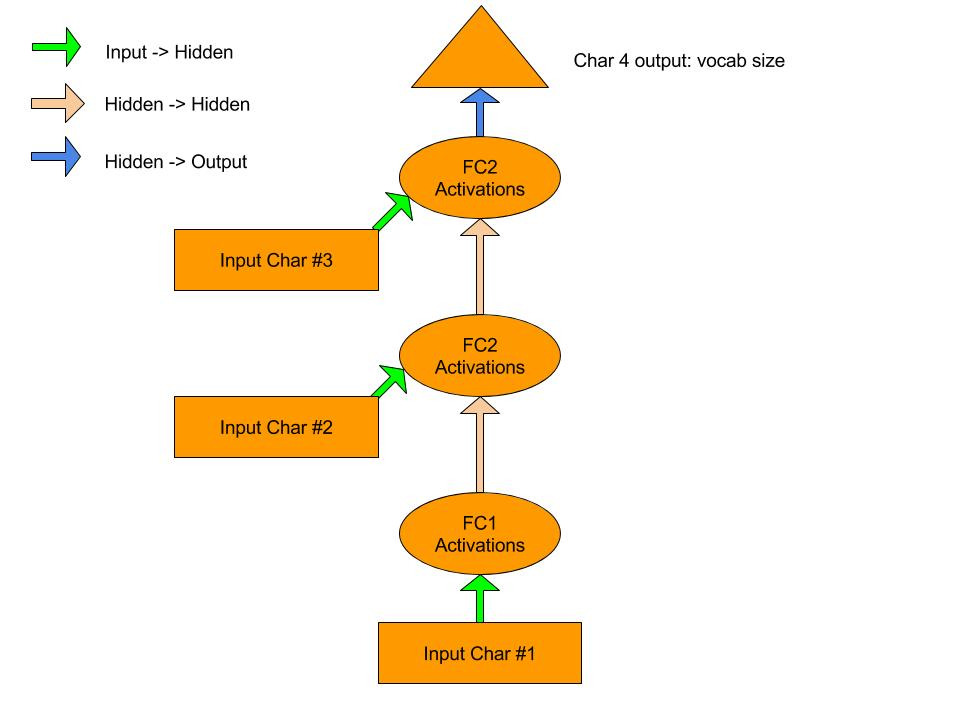

In [14]:
Image.open('x/3-character NN.jpg')

In [15]:
class Char3Model_SELU(nn.Module):
    def __init__(self, vocab_size, n_fac):
        super().__init__()
        self.e = nn.Embedding(vocab_size, n_fac)
        
        self.l_in = nn.Linear(n_fac, n_hidden)
        self.l_hidden = nn.Linear(n_hidden, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        
    def forward(self, c1, c2, c3):
        in1 = F.selu(self.l_in(self.e(c1)))
        in2 = F.selu(self.l_in(self.e(c2)))
        in3 = F.selu(self.l_in(self.e(c3)))
        
        h = V(torch.zeros(in1.size()).cuda())
        h = F.tanh(self.l_hidden(h+in1))
        h = F.tanh(self.l_hidden(h+in2))
        h = F.tanh(self.l_hidden(h+in3))
        return F.log_softmax(self.l_out(h))

In [16]:
md = ColumnarModelData.from_arrays('.', [-1], np.stack([x1, x2, x3], axis=1), y, bs=512)

In [17]:
m = Char3Model_SELU(vocab_size, n_fac).cuda()

In [18]:
it = iter(md.trn_dl)
*xs, yt = next(it)
t = m(*V(xs))

In [19]:
lo = LayerOptimizer(optim.Adam, m, 1e-3, 1e-5)

In [20]:
fit(m, md, 1, lo.opt, F.nll_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                           
    0      3.619806   0.920701  



/home/bmn/src/ai.learn/fast.ai/fastai/courses/dl1/fastai/core.py:23: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  x = Variable(T(x), volatile=volatile, requires_grad=requires_grad)


[0.92070127]

In [21]:
set_lrs(lo.opt, 0.001)

In [22]:
fit(m, md, 1, lo.opt, F.nll_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      2.842869   0.586609  



/home/bmn/src/ai.learn/fast.ai/fastai/courses/dl1/fastai/core.py:23: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  x = Variable(T(x), volatile=volatile, requires_grad=requires_grad)


[0.58660889]

In [23]:
def get_next(inp):
    idxs = T(np.array([char_indices[c] for c in inp]))
    p = m(*VV(idxs))
    i = np.argmax(to_np(p))
    return chars[i]

In [24]:
get_next('r. ')

/home/bmn/src/ai.learn/fast.ai/fastai/courses/dl1/fastai/core.py:23: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  x = Variable(T(x), volatile=volatile, requires_grad=requires_grad)


'('

In [25]:
get_next('per')

/home/bmn/src/ai.learn/fast.ai/fastai/courses/dl1/fastai/core.py:23: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  x = Variable(T(x), volatile=volatile, requires_grad=requires_grad)


'\n'

In [26]:
get_next(' to')

/home/bmn/src/ai.learn/fast.ai/fastai/courses/dl1/fastai/core.py:23: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  x = Variable(T(x), volatile=volatile, requires_grad=requires_grad)


'r'

In [27]:
get_next('gra')

/home/bmn/src/ai.learn/fast.ai/fastai/courses/dl1/fastai/core.py:23: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  x = Variable(T(x), volatile=volatile, requires_grad=requires_grad)


'r'

In [28]:
get_next('wom')

/home/bmn/src/ai.learn/fast.ai/fastai/courses/dl1/fastai/core.py:23: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  x = Variable(T(x), volatile=volatile, requires_grad=requires_grad)


'a'